# Performance Evaluation
### hwang9u

In [1]:
import os
os.chdir('../source/')

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import torch
from torch.utils.data import DataLoader
from model import EmoCatcher
from dataset import RAVDESSMelS, emotion_dict
from dataloader import get_meta, split_meta, mels2batch
from utils.evaluation import create_confusion_matrix, average_recall
from utils.evaluation import plot_cm, plot_metric_curve, plot_predicted_example
os.chdir('../')

## 1. Hold-Out

In [3]:
dataset_dir ="../../../dataset/ravdess/"
n_class = 8

# Extract meta information from .wav file name and split into train/test (+ stratified)
meta = get_meta(dataset_dir)
mel_kwargs = {"n_mels":64, "fmax": 6000, "win_length": 2048, "hop_length" :2048//3*2, "n_fft": 2048*2} 
train_meta, test_meta = split_meta(meta, kfcv=False, test_ratio=.2, stratify=True, target='emotion', random_state=999)
# test dataset
test_dset = RAVDESSMelS(dataset_dir= dataset_dir , mel_specs_kwargs=mel_kwargs,speech_list=test_meta.speech_list.tolist())
# test dataloader
test_dloader = DataLoader(test_dset, batch_size= 64, collate_fn=mels2batch, shuffle=False)


size: 1152, 288
ratio: 0.8, 0.2


### 1.1 Metric Curves: Accuracy, Loss

In [4]:
holdout_outdir = 'output/holdout/'

Best Test Accuracy / Loss: 87.15% / 0.86552


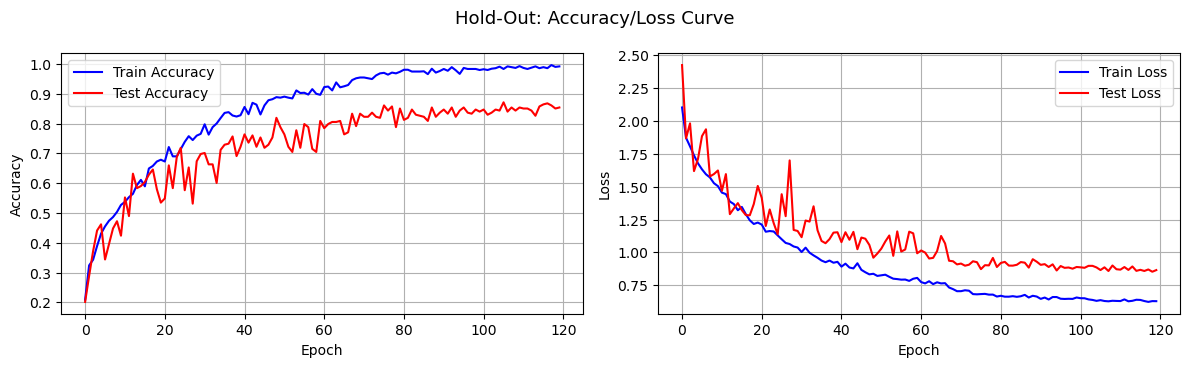

In [5]:
# Load metric log dictionary
with open(f'./{holdout_outdir}/logs/metric_log_dict.pkl', 'rb') as f:
    metric_log_dict = pickle.load(f)
fig = plot_metric_curve(metric_log_dict['train'].values(), metric_log_dict['test'].values(), plot_kwargs={'figsize': (12,3.7), 'dpi': 100})
fig.suptitle('Hold-Out: Accuracy/Loss Curve', size = 13)
fig.tight_layout()
fig.savefig(f'{holdout_outdir}img/metric_curves.jpg')
test_best_acc_ind = np.argmax(metric_log_dict['test']['acc'])
print('Best Test Accuracy / Loss: {:.2f}% / {:.5f}'.format(metric_log_dict['test']['acc'][test_best_acc_ind]*100, metric_log_dict['test']['loss'][test_best_acc_ind])) 

#### - Last 10 epochs

In [6]:
for type in ['train', 'test']:
    for m in ['acc', 'loss']:
        print('{} {} (mean ± std): {:.5f}(± {:.5f})'.format(type.capitalize(), m.capitalize(), np.mean(metric_log_dict[type][m][-10:-1]), np.std(metric_log_dict[type][m][-10:-1])))
    print('\n')

Train Acc (mean ± std): 0.98881(± 0.00367)
Train Loss (mean ± std): 0.63214(± 0.00590)


Test Acc (mean ± std): 0.85262(± 0.01182)
Test Loss (mean ± std): 0.86931(± 0.01257)




### with Best Model
#### - Load trained model

In [7]:
## best model path
import glob
model_path = glob.glob(f"./{holdout_outdir}/model/best_model*.pth")[0]

## load trained model
model = EmoCatcher(input_dim=64, hidden_dim=128, kernel_size=3)
model.load_state_dict( torch.load(model_path))

<All keys matched successfully>

### 1.2 Create Confusion Matrix

    Accuracy metric is the same as WAR(Weighted Average Recall) since I did stratified sampling.

In [8]:
model.eval()
cm_test = create_confusion_matrix(model, test_dloader, n_class=8)

Accuracy: 0.8715277910232544


In [9]:
print('Accuracy: {:.4f}'.format(cm_test.trace()/cm_test.sum() ))
print('UAR(Unweighted Average Recall): {:.4f}\nWAR(Weighted Average Recall): {:.4f}'.format(average_recall(cm_test, weighted=False), average_recall(cm_test, weighted=True)))

Accuracy: 0.8715
UAR(Unweighted Average Recall): 0.8666
WAR(Weighted Average Recall): 0.8715


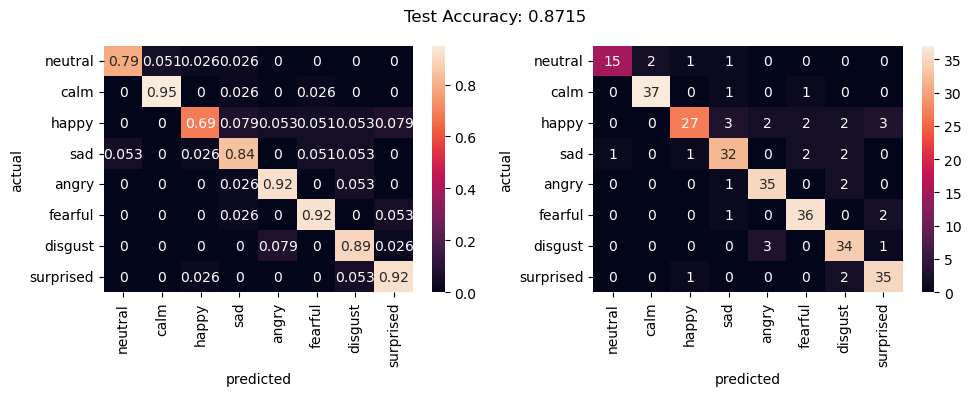

In [10]:
fig, axes = plt.subplots(1,2, figsize = (10, 4), dpi = 100)
plot_cm(cm_test, normalize=True, ax = axes[0])
plot_cm(cm_test, normalize=False, ax = axes[1])
fig.suptitle('Test Accuracy: {:.4f}'.format(cm_test.trace()/ cm_test.sum()))
plt.tight_layout()
plt.savefig(f'./{holdout_outdir}/img/cm.jpg')

### 1.3 Visualizaing Attention Weights

In [11]:
test_dloader = DataLoader(test_dset, batch_size= len(test_dset), collate_fn=mels2batch, shuffle=False)
samples = next(iter(test_dloader))
mel_specs, label, L = samples
out, att = model(mel_specs, L, return_attention_weights = True )

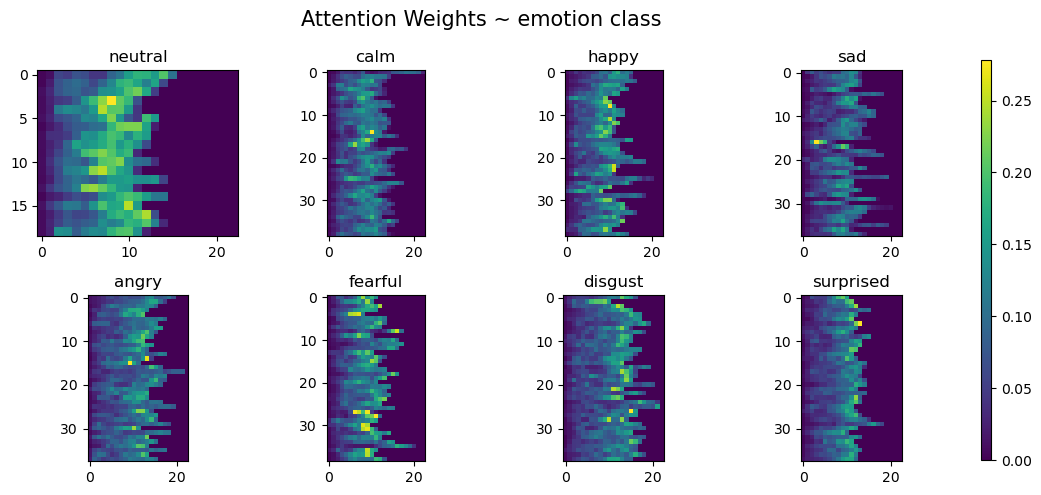

In [12]:
fig, axes = plt.subplots(2, 4, figsize = (10,5), dpi = 100)
for l in range(n_class):
    im = axes[l//4][l%4].imshow(att.squeeze(-1).detach()[torch.where(label == l)[0]])
    axes[l//4][l%4].set_title('{}'.format(emotion_dict[ f"0{l+1}"]))
fig.suptitle('Attention Weights ~ emotion class', size = 15)
fig.tight_layout()
cbar_ax = fig.add_axes([1, 0.08, 0.01, 0.8])
fig.colorbar(im, cbar_ax)
plt.savefig(f'./{holdout_outdir}/img/attention_weights.jpg')

### 1.4 Predicted Examples
* plot title: true emotion class/predicted emotion class(predicted probability x 100 %) 


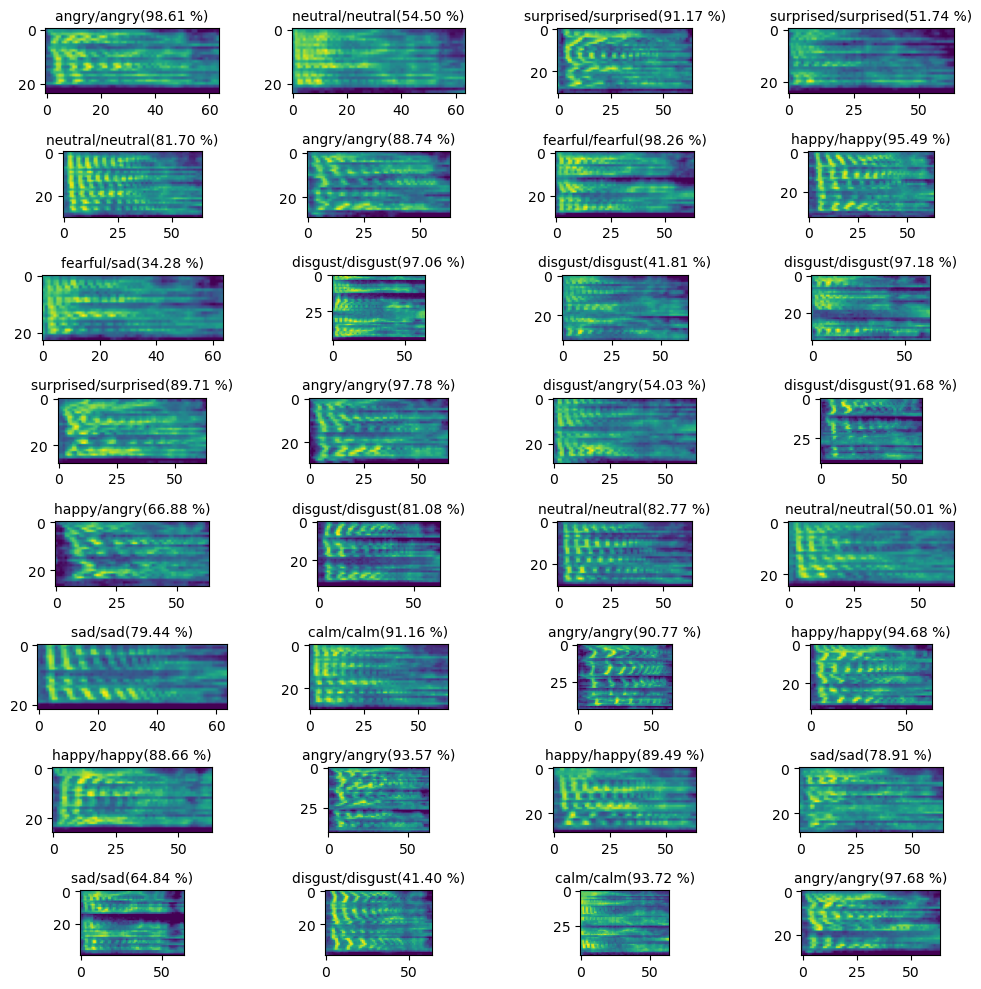

In [13]:
torch.manual_seed(1)
test_sample_dloader = DataLoader(test_dset, batch_size= 32, collate_fn=mels2batch, shuffle=True)
samples = next(iter(test_sample_dloader))
plot_predicted_example(samples, model, figsize = (10, 10), title_font_size=10)
plt.savefig(f'./{holdout_outdir}/img/predicted_examples.jpg')

### 2. K-Fold CV Result

In [14]:
cv_outdir = './output/cv5/'
splitted_meta = split_meta(meta, kfcv=True, n_splits=5, stratify=True, target='emotion', random_state=999)

size: 1152, 288
ratio: 0.8, 0.2


### 2.1 Metric Curves: Accuracy, Loss

[Fold 1] Best Test Accuracy: 0.84375 / Loss: 0.97918
[Fold 2] Best Test Accuracy: 0.80903 / Loss: 1.04934
[Fold 3] Best Test Accuracy: 0.85764 / Loss: 0.87293
[Fold 4] Best Test Accuracy: 0.87500 / Loss: 0.90747
[Fold 5] Best Test Accuracy: 0.82292 / Loss: 0.98223
[5-Fold CV Best Test Accuracy] max: 0.87500 min: 0.80903 mean: 0.84167 std: 0.02361


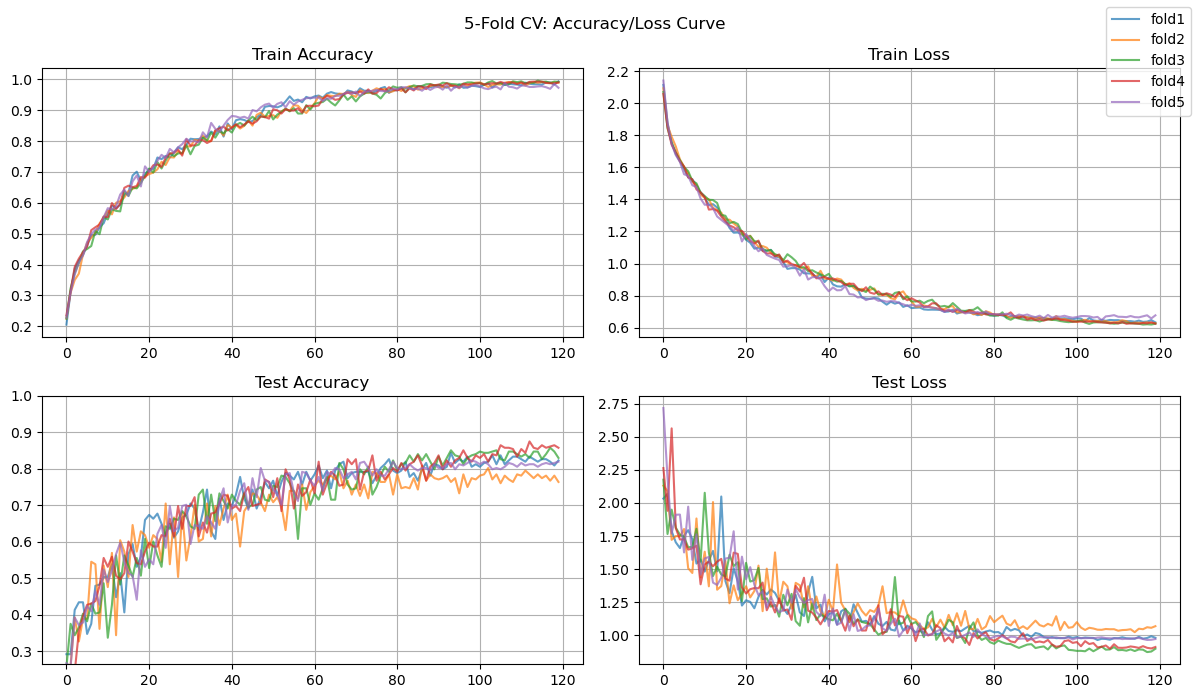

In [15]:
best_test_acc_list = []
fig, axes = plt.subplots(2,2, figsize = (12,7), dpi = 100)
for k in range(5):
    with open(cv_outdir+f'logs/fold{k+1}_metric_log_dict.pkl', 'rb') as f:
        metric_log_dict = pickle.load(f)
    for i in range(4):
        axes[i//2][i%2].grid()
    
    axes[0][0].plot(metric_log_dict['train']['acc'], alpha = .7)
    axes[0][0].set_title('Train Accuracy')
    
    axes[0][1].plot(metric_log_dict['train']['loss'], alpha = .7)
    axes[0][1].set_title('Train Loss')
    
    axes[1][0].plot(metric_log_dict['test']['acc'], alpha = .7)
    axes[1][0].set_ylim( bottom = None, top = 1)
    axes[1][0].set_title('Test Accuracy')
    
    axes[1][1].plot(metric_log_dict['test']['loss'], alpha = .7)
    axes[1][1].set_title('Test Loss')
    

    best_test_acc_ind, best_test_acc = np.argmax(metric_log_dict['test']['acc']), np.max(metric_log_dict['test']['acc'])       
    best_test_acc_list.append(best_test_acc)
    print('[Fold {}] Best Test Accuracy: {:.5f} / Loss: {:.5f}'.format(k+1, best_test_acc, metric_log_dict['test']['loss'][best_test_acc_ind] ))

fig.suptitle('5-Fold CV: Accuracy/Loss Curve')
fig.legend(labels = list(map(lambda i: f'fold{i+1}', list(range(5)))), loc = 'upper right')

print('[5-Fold CV Best Test Accuracy] max: {:.5f} min: {:.5f} mean: {:.5f} std: {:.5f}'.format(np.max(best_test_acc_list), 
                                                                                         np.min(best_test_acc_list),
                                                                                         np.mean(best_test_acc_list),
                                                                                         np.std(best_test_acc_list)))
fig.tight_layout()
fig.savefig(f'{cv_outdir}img/metric_curves.jpg')


### 2.2 Create Confusion Matrix across folds


Accuracy: 0.84375


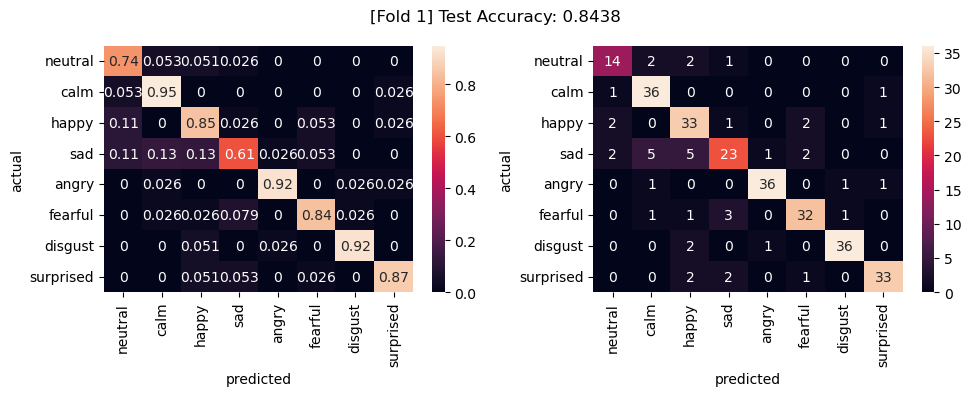

Accuracy: 0.8090277910232544


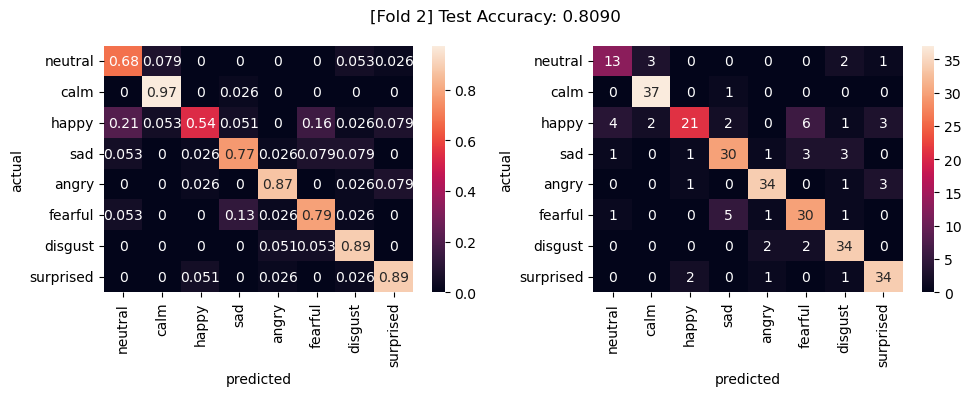

Accuracy: 0.8576388955116272


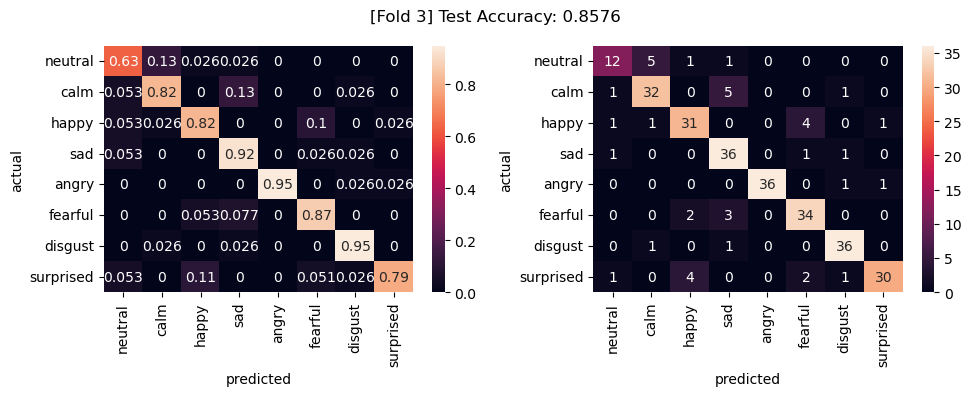

Accuracy: 0.875


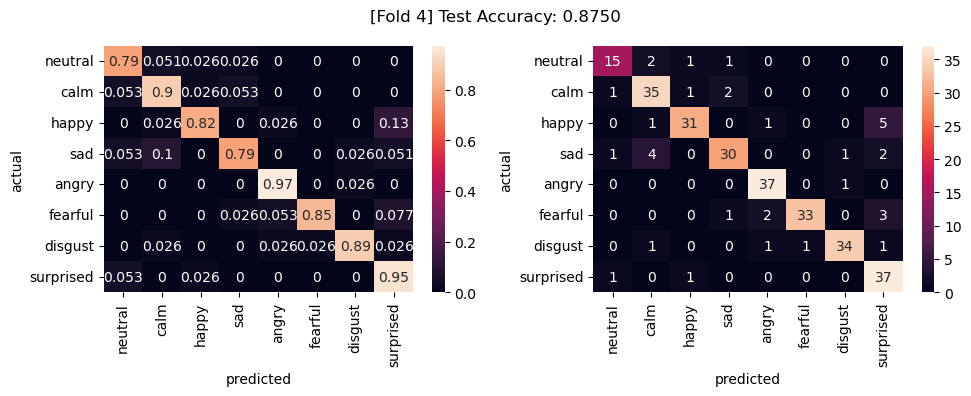

Accuracy: 0.8229166865348816


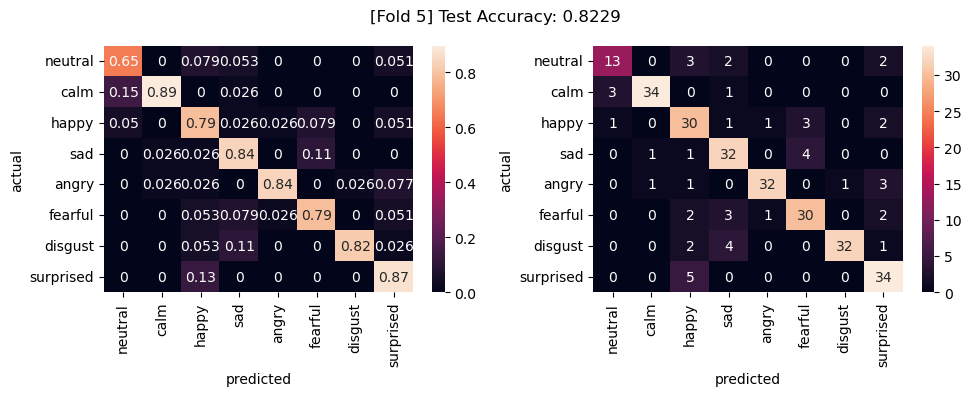

In [16]:
for k, (tr, ts) in enumerate(splitted_meta):
    # get folddd
    train_meta = meta.iloc[tr, :]
    test_meta = meta.iloc[ts, :]
    test_dset = RAVDESSMelS(dataset_dir= dataset_dir , mel_specs_kwargs=mel_kwargs,speech_list=test_meta.speech_list.tolist())
    # test dataloader
    test_dloader = DataLoader(test_dset, batch_size= 64, collate_fn=mels2batch, shuffle=False)

    model_path = glob.glob(f"./{cv_outdir}/model/fold{k+1}/best_model*.pth")[0]

    ## load trained model
    model = EmoCatcher(input_dim=mel_kwargs['n_mels'], hidden_dim=128, kernel_size=3)
    model.load_state_dict( torch.load(model_path))
    model.eval()
    cm_test = create_confusion_matrix(model, test_dloader, n_class=8)
    fig, axes = plt.subplots(1,2, figsize = (10, 4), dpi = 100)
    plot_cm(cm_test, normalize=True, ax = axes[0])
    plot_cm(cm_test, normalize=False, ax = axes[1])
    fig.suptitle('[Fold {}] Test Accuracy: {:.4f}'.format(k+1, cm_test.trace()/ cm_test.sum()))
    plt.tight_layout()
    plt.savefig(f'./{cv_outdir}/img/cm_f{k+1}.jpg')
    plt.show()